In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import Dropout
from keras.engine.sequential import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD

In [79]:
# data_path = 'tweets_sentiment_score_price_10min_20210205_20220218.csv'
# data = pd.read_csv(data_path).drop(['10min_TimeStart', 'time_period_end', 'time_open', 'time_close'], axis=1)
data_path = 'data/30MIN_Full_Dataset.csv'
data = pd.read_csv(data_path)
data = data.drop(['timestamp'], axis=1)

data.head()

,price_open,price_high,price_low,price_close,volume_traded,vader_pos,vader_neg,vader_neu,vader_compound,pos_count,neg_count,neu_count,MACD,SMA,OBV,RSI,MFI,pos_keywords_occur,neg_keywords_occur
0,4734.26,4749.24,4725.05,4739.59,141.314466,0.0,0.0,1.0,0.0,0,0,0,20.964923,4735.542,1775.306283,53.892662,79.353578,0,0
1,4735.97,4765.21,4735.97,4763.99,194.869532,0.0,0.0,1.0,0.0,0,0,0,22.911362,4742.338,1970.175815,56.301964,34.203416,0,0
2,4764.00,4777.76,4756.79,4775.96,186.942639,0.0,0.0,1.0,0.0,0,0,0,23.866233,4749.236,2157.118453,56.446413,14.027660,0,0
3,4765.02,4776.17,4763.00,4771.30,64.006437,0.0,0.0,1.0,0.0,0,0,0,23.494495,4757.020,2093.112016,57.260563,33.764092,0,0
4,4769.71,4771.26,4743.48,4754.00,189.090373,0.0,0.0,1.0,0.0,0,0,0,22.114438,4760.968,1904.021643,55.426788,87.661717,0,0


In [80]:
'''Price Data:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator in 30 MIN data:'''
data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count', 'pos_keywords_occur', 'neg_keywords_occur'], axis=1)

data_labels = data['price_close']

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))


train_size1 = int(0.8 * len(label))
train_size2 = int(0.9 * len(label))

In [81]:
def split_data(f, l, delay):
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

GRU_window_size = 5
LSTM_window_size = 5

X_train_GRU, y_train_GRU = split_data(feature[:train_size1], label[:train_size1], GRU_window_size)
X_train_LSTM, y_train_LSTM = split_data(feature[:train_size1], label[:train_size1], LSTM_window_size)
X_train2_GRU, y_train2_GRU = split_data(feature[train_size1:train_size2], label[train_size1:train_size2], GRU_window_size)
X_train2_LSTM, y_train2_LSTM = split_data(feature[train_size1:train_size2], label[train_size1:train_size2], LSTM_window_size)
X_test_GRU, y_test_GRU = split_data(feature[train_size2:], label[train_size2:], GRU_window_size)
X_test_LSTM, y_test_LSTM = split_data(feature[train_size2:], label[train_size2:], LSTM_window_size)

# Define Base Models

In [82]:
nGRU = 7
nLSTM = 3

In [83]:
GRUs = [
    keras.Sequential([
        layers.GRU(512),
        layers.Dense(512),
        layers.Dense(1)
    ]) for i in range(nGRU)
]

LSTMs = [
    keras.Sequential([
        layers.LSTM(1024),
        layers.Dropout(0.2),
        layers.Dense(1)
    ]) for i in range(nLSTM)
]

# Train Models

In [84]:
# for i, model in enumerate(GRUs):
#     model.compile(loss='mean_squared_error',
#                   optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
#                   metrics=[keras.metrics.RootMeanSquaredError()]
#                   )
#     history = model.fit(X_train_GRU, y_train_GRU,
#                         epochs=30,
#                         batch_size=4,
#                         validation_data=(X_train2_GRU, y_train2_GRU),
#                         callbacks=[keras.callbacks.ModelCheckpoint('gru-1day-'+str(i)+'.h5', verbose=1, monitor='val_root_mean_squared_error',save_best_only=True, mode='auto')],
#                         shuffle=True
#                         )

In [85]:
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
DECAY_RATE = -0.6

def lr_scheduler(epoch, lr):
    if epoch % 10== 0 and epoch > 0:
        lr *= tf.math.exp(DECAY_RATE)
    
    return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

for i, model in enumerate(LSTMs):
  model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[tf.keras.metrics.RootMeanSquaredError()])
  history = model.fit(X_train_LSTM, y_train_LSTM, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=(X_train2_LSTM, y_train2_LSTM), 
                    shuffle=False,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='lstm-1day-'+str(i)+'.h5', monitor='val_root_mean_squared_error', mode='min', save_best_only=True,  verbose=1), lr_scheduler_callback]
                    )

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
2995/2995 [==============================] - 19s 6ms/step - loss: 1.3788e-04 - root_mean_squared_error: 0.0117 - val_loss: 2.9738e-04 - val_root_mean_squared_error: 0.0172

Epoch 00001: val_root_mean_squared_error improved from inf to 0.01724, saving model to lstm-1day-0.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
2995/2995 [==============================] - 17s 6ms/step - loss: 6.9781e-05 - root_mean_squared_error: 0.0084 - val_loss: 9.1639e-04 - val_root_mean_squared_error: 0.0303

Epoch 00002: val_root_mean_squared_error did not improve from 0.01724
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
2995/2995 [==============================] - 20s 7ms/step - loss: 1.0696e-04 - root_mean_squared_error: 0.0103 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357

Epoch 00003: val_root_mean_s

# Predict Results for Base Models

In [86]:
GRU = [tf.keras.models.load_model('gru-1day-'+str(i)+'.h5') for i in range(nGRU)]
LSTM = [tf.keras.models.load_model('lstm-1day-'+str(i)+'.h5') for i in range(nLSTM)]

In [87]:
pred_GRU = [model.predict(X_test_GRU) for model in GRU]
pred_LSTM = [model.predict(X_test_LSTM) for model in LSTM]

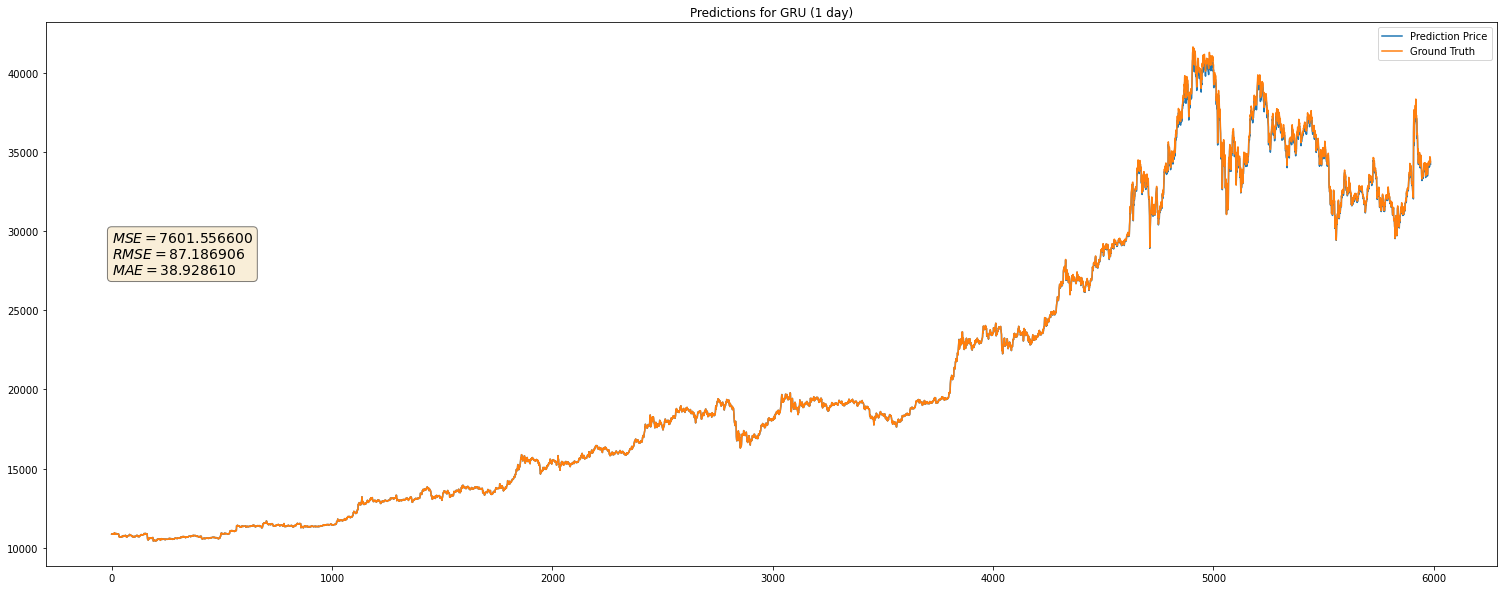

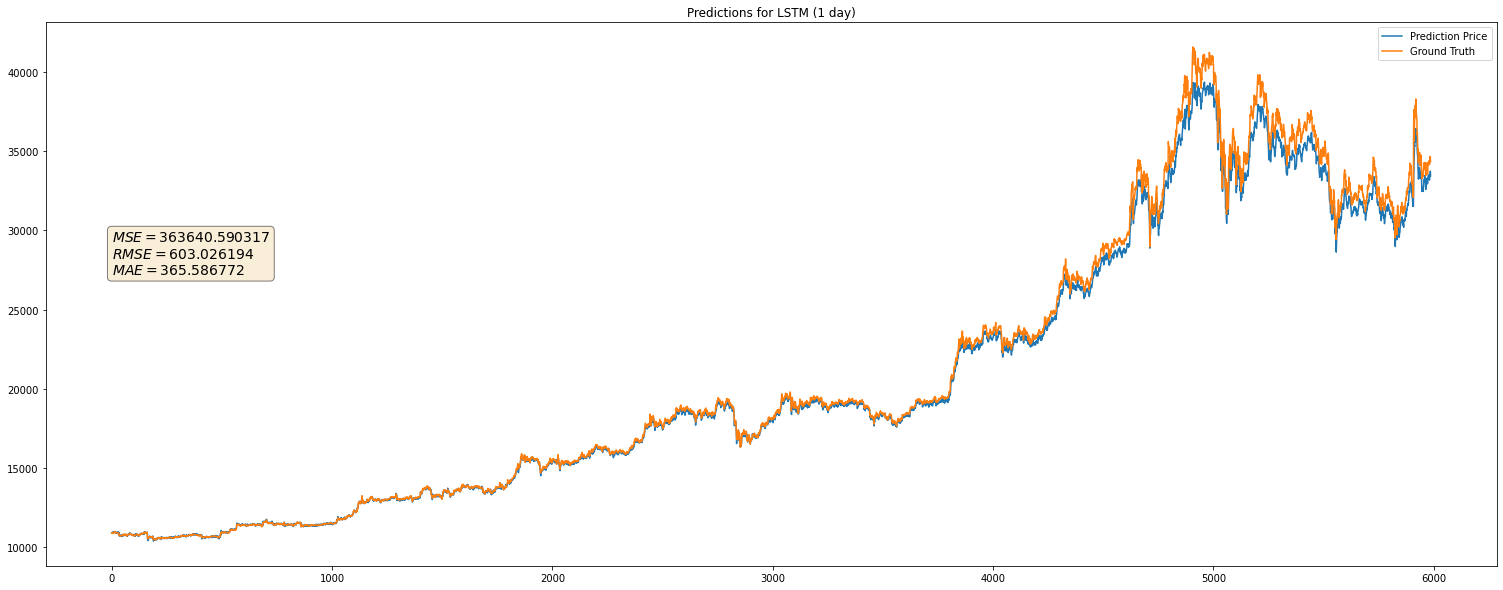

In [88]:
prediction = np.mean(np.array(pred_GRU), axis=0)
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test_GRU.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for GRU (1 day)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()


prediction = np.mean(np.array(pred_LSTM), axis=0)
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test_LSTM.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for LSTM (1 day)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()

In [89]:
pred_GRU = [model.predict(X_train2_GRU) for model in GRU]
pred_LSTM = [model.predict(X_train2_LSTM) for model in LSTM]
pred_LSTM = np.array(pred_LSTM)
pred_GRU = np.array(pred_GRU)

tmp = np.concatenate((pred_GRU, pred_LSTM), axis=0).squeeze().transpose()
# tmp = pred_GRU.squeeze().transpose()

In [90]:
batch_size = 8
model = Sequential([
                    Dense(50),
                    Dense(100),

                    # Activation('relu'),
                    # Dropout(0.2),
                    Dense(25),
                    Dense(1)
                    ])

model.compile(optimizer= Adam(learning_rate=5e-4), loss='mse', metrics=['accuracy'])

model.fit(tmp, y_train2_GRU, batch_size = batch_size, epochs=50, verbose = 1)

Epoch 1/50
749/749 [==============================] - 1s 1ms/step - loss: 1.5359e-04 - accuracy: 0.0000e+00
Epoch 2/50
749/749 [==============================] - 1s 1ms/step - loss: 7.5334e-08 - accuracy: 0.0000e+00
Epoch 3/50
749/749 [==============================] - 1s 974us/step - loss: 9.1866e-08 - accuracy: 0.0000e+00
Epoch 4/50
749/749 [==============================] - 1s 970us/step - loss: 1.3777e-07 - accuracy: 0.0000e+00
Epoch 5/50
749/749 [==============================] - 1s 966us/step - loss: 5.1139e-07 - accuracy: 0.0000e+00
Epoch 6/50
749/749 [==============================] - 1s 995us/step - loss: 2.9487e-06 - accuracy: 0.0000e+00
Epoch 7/50
749/749 [==============================] - 1s 1ms/step - loss: 2.0664e-06 - accuracy: 0.0000e+00
Epoch 8/50
749/749 [==============================] - 1s 980us/step - loss: 2.6186e-06 - accuracy: 0.0000e+00
Epoch 9/50
749/749 [==============================] - 1s 979us/step - loss: 2.3133e-06 - accuracy: 0.0000e+00
Epoch 10/50
749/

# Prediction for Meta-Model

In [91]:
pred_GRU = [model.predict(X_test_GRU) for model in GRU]
pred_LSTM = [model.predict(X_test_GRU) for model in LSTM]

pred_LSTM = np.array(pred_LSTM)
pred_GRU = np.array(pred_GRU)

tmp2 = np.concatenate((pred_GRU, pred_LSTM), axis=0).squeeze().transpose()
# tmp2 = pred_GRU.squeeze().transpose()

# tmp2 = np.concatenate((pred_GRU, pred_LSTM), axis=1)
print(tmp2.shape)
# tmp2 = np.squeeze(tmp2, axis=2).transpose()
prediction = model.predict(tmp2)


(5986, 10)


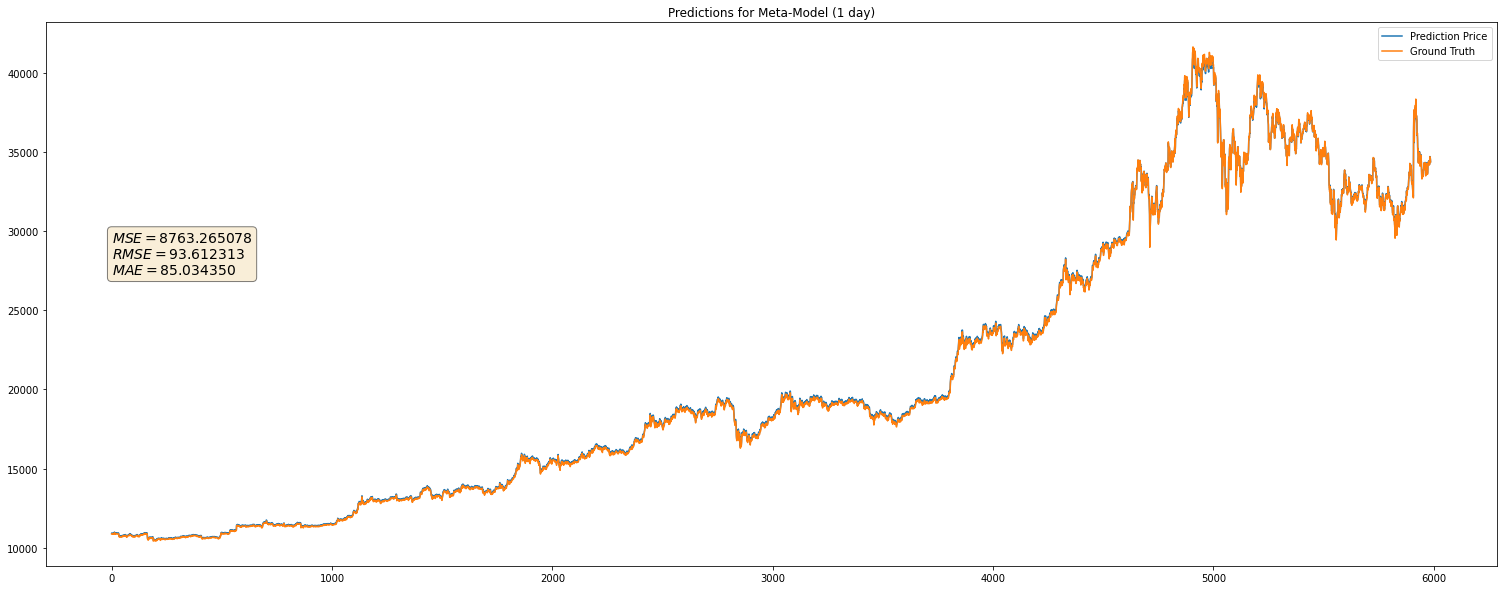

In [92]:
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test_GRU.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for Meta-Model (1 day)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()